In [1]:
# Import the modules
from sklearn.externals import joblib
from sklearn import datasets
from skimage.feature import hog
from sklearn.svm import LinearSVC
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
import os

In [84]:
# Input
input_img = cv2.imread('test10.png')

(<matplotlib.axes._subplots.AxesSubplot at 0x1c2d4a58d0>,
 Text(0.5,1,'Self implement warpPerspective'))

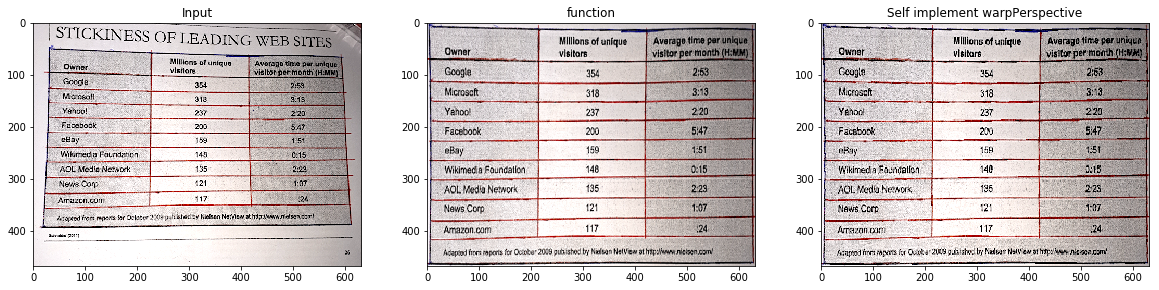

In [85]:
# Geomatric transform
# Projective
def getPerspective(src, res):
    src_x1, src_x2, src_x3, src_x4 = src[:, 0]
    src_y1, src_y2, src_y3, src_y4 = src[:, 1]
    dst_x1, dst_x2, dst_x3, dst_x4 = res[:, 0]
    dst_y1, dst_y2, dst_y3, dst_y4 = res[:, 1]
    
    A = np.float32([[src_x1, src_y1, 1, 0, 0, 0, -(src_x1 * dst_x1), -(dst_x1 * src_y1)],
                  [0, 0, 0, src_x1, src_y1, 1, -(src_x1 * dst_y1), -(dst_y1 * src_y1)],
                  [src_x2, src_y2, 1, 0, 0, 0, -(src_x2 * dst_x2), -(dst_x2 * src_y2)],
                  [0, 0, 0, src_x2, src_y2, 1, -(src_x2 * dst_y2), -(dst_y2 * src_y2)],
                  [src_x3, src_y3, 1, 0, 0, 0, -(src_x3 * dst_x3), -(dst_x3 * src_y3)],
                  [0, 0, 0, src_x3, src_y3, 1, -(src_x3 * dst_y3), -(dst_y3 * src_y3)],
                  [src_x4, src_y4, 1, 0, 0, 0, -(src_x4 * dst_x4), -(dst_x4 * src_y4)],
                  [0, 0, 0, src_x4, src_y4, 1, -(src_x4 * dst_y4), -(dst_y4 * src_y4)]])
    
    b = np.float32([dst_x1, dst_y1,
                  dst_x2, dst_y2,
                  dst_x3, dst_y3,
                  dst_x4, dst_y4])
  
    inverseA = np.linalg.inv(A)
    h = np.matmul(inverseA, b)
    M = np.float32([
        [h[0], h[1], h[2]],
        [h[3], h[4], h[5]],
        [h[6], h[7], 1]])
    
    return M

def warpPerspective(img, size, M):
    rows, cols = size
    for y in range(0, rows):
        for x in range(0, cols):
            P_prime = [x, y, 1]
            src_x = int(round(np.dot(M[0], P_prime) / np.dot(M[2], P_prime)))
            src_y = int(round(np.dot(M[1], P_prime) / np.dot(M[2], P_prime)))
            dst[y][x] = shapes_rgb[src_y][src_x]
    return dst


shapes_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
rows, cols, ch = shapes_rgb.shape

A = np.float32([[28, 45], [14, 397], [616, 393], [597, 58]])

B = np.float32([[0, 0], [0, rows], [cols, rows], [cols, 0]])


dst = np.ones((rows, cols, ch), dtype=np.int32)

M = getPerspective(A, B)
inverseM = np.linalg.inv(M)
dst = warpPerspective(shapes_rgb, (rows, cols), inverseM)

M_func = cv2.getPerspectiveTransform(A, B)
shapes = cv2.warpPerspective(shapes_rgb, M_func, (cols, rows))

plt.figure(figsize=(20, 20))
plt.subplot(131), plt.imshow(shapes_rgb), plt.title('Input')
plt.subplot(132), plt.imshow(shapes), plt.title('function')
plt.subplot(133), plt.imshow(dst), plt.title('Self implement warpPerspective')

(<matplotlib.image.AxesImage at 0x1c2a9b9c18>, Text(0.5,1,'Result'))

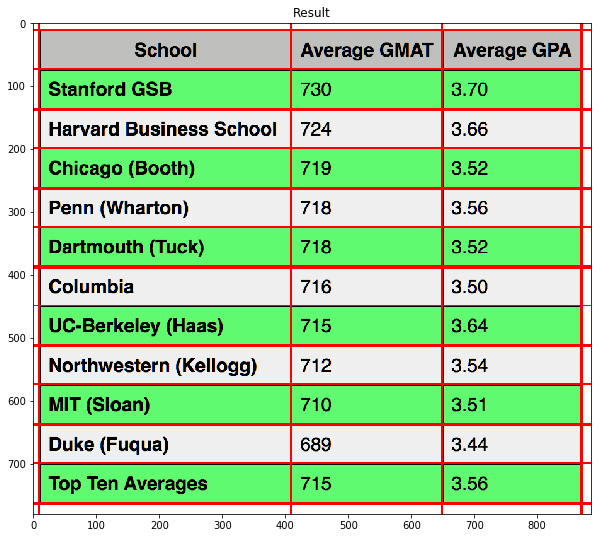

In [2]:
shapes = cv2.imread('mba1.png')
shapes_grayscale = cv2.cvtColor(shapes, cv2.COLOR_RGB2GRAY)

canny_edges = cv2.Canny(shapes_grayscale, 100, 200)

def hough_lines_acc(img, rho_resolution=1, theta_resolution=1):
    height, width = img.shape # we need heigth and width to calculate the diag
    img_diagonal = np.ceil(np.sqrt(height**2 + width**2)) # a**2 + b**2 = c**2
    rhos = np.arange(-img_diagonal, img_diagonal + 1, rho_resolution)
    thetas = np.deg2rad(np.arange(-90, 90, theta_resolution))

    H = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img) # find all edge (nonzero) pixel indexes

    for i in range(len(x_idxs)): # cycle through edge points
        x = x_idxs[i]
        y = y_idxs[i]

        for j in range(len(thetas)): # cycle through thetas and calc rho
            rho = int((x * np.cos(thetas[j]) +
                       y * np.sin(thetas[j])) + img_diagonal)
            H[rho, j] += 1

    return H, rhos, thetas

def hough_peaks(H, num_peaks, threshold=0, nhood_size=3):
    indicies = []
    H1 = np.copy(H)
    for i in range(num_peaks):
        idx = np.argmax(H1) # find argmax in flattened array
        H1_idx = np.unravel_index(idx, H1.shape) # remap to shape of H
        indicies.append(H1_idx)

        # surpess indicies in neighborhood
        idx_y, idx_x = H1_idx # first separate x, y indexes from argmax(H)
        # if idx_x is too close to the edges choose appropriate values
        if (idx_x - 1) < 0: min_x = 0
        else: min_x = idx_x - 1
        if ((idx_x + 1) > H.shape[1]): max_x = H.shape[1]
        else: max_x = idx_x + 1

        # if idx_y is too close to the edges choose appropriate values
        if (idx_y - 1) < 0: min_y = 0
        else: min_y = idx_y - 1
        if ((idx_y + 1) > H.shape[0]): max_y = H.shape[0]
        else: max_y = idx_y + 1

        # bound each index by the neighborhood size and set all values to 0
        for x in range(min_x, max_x):
            for y in range(min_y, max_y):
                # remove neighborhoods in H1
                H1[y, x] = 0

    # return the indicies and the original Hough space with selected points
    return indicies, H

def hough_lines_draw(img, indicies, rhos, thetas):

    for i in range(len(indicies)):
        rho = rhos[indicies[i][0]]
        theta = thetas[indicies[i][1]]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        # these are then scaled so that the lines go off the edges of the image
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 2)


# run hough_lines_accumulator on the shapes canny_edges image
H, rhos, thetas = hough_lines_acc(canny_edges)
indicies, H = hough_peaks(H, 24) # find peaks
hough_lines_draw(shapes, indicies, rhos, thetas)

# Show image with manual Hough Transform Lines
plt.figure(figsize=(10, 10))
plt.imshow(shapes), plt.title('Result')

(<matplotlib.axes._subplots.AxesSubplot at 0x1c29fc3748>,
 Text(0.5,1,'Output'))

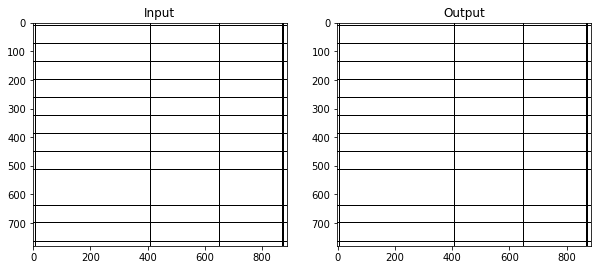

In [3]:
blank_image = np.ones(shapes.shape, dtype=np.int16)*255
hough_lines_draw(blank_image, indicies, rhos, thetas)

# write the detected line and read 
cv2.imwrite('line_detected.png', blank_image)
line_detected = cv2.imread('line_detected.png', 0)
#

(thresh, img_bin) = cv2.threshold(line_detected, 250, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(line_detected, cmap="gray"), plt.title('Input')
plt.subplot(122), plt.imshow(img_bin, cmap="gray"), plt.title('Output')

In [4]:
# find the contours
im2, contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

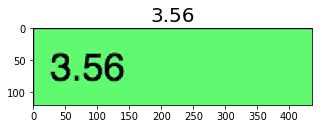

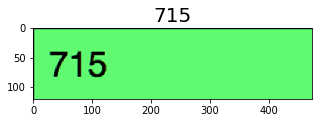

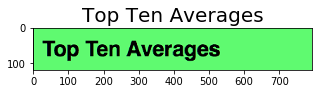

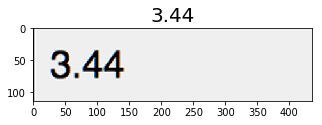

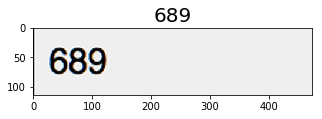

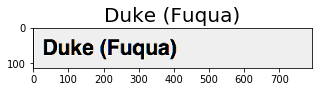

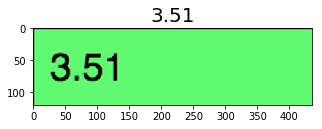

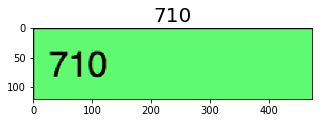

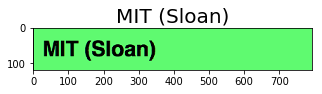

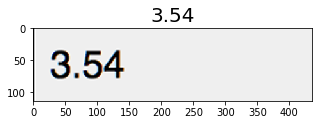

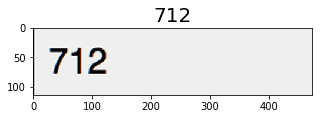

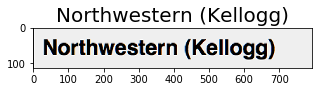

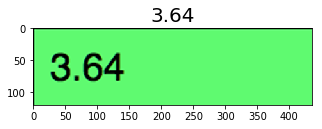

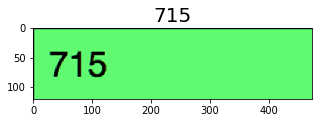

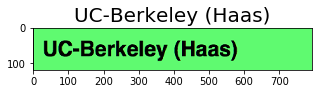

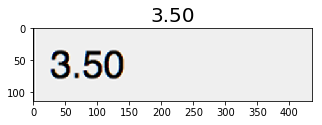

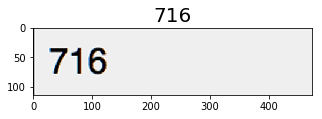

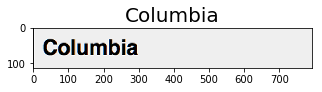

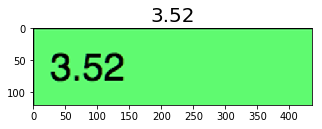

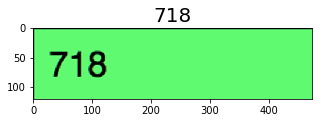

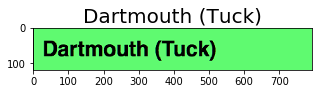

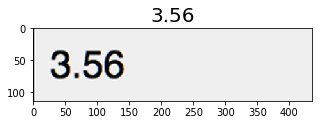

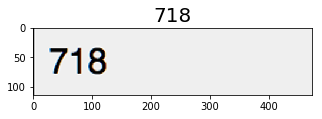

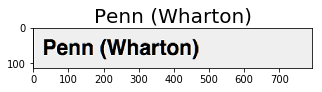

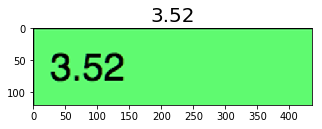

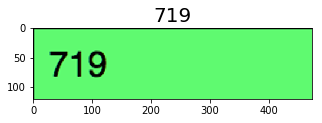

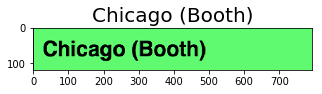

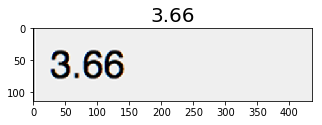

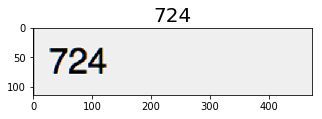

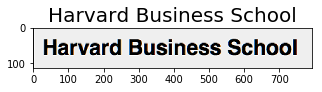

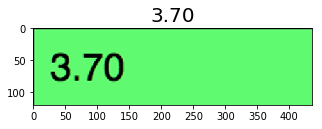

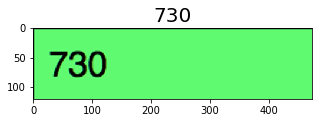

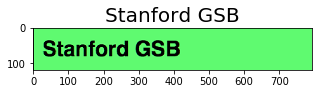

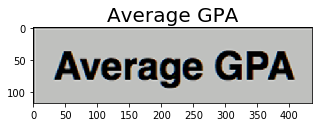

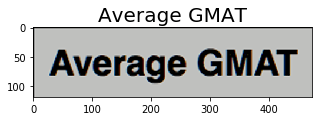

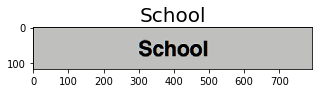

In [35]:
idx = 0
directory = 'outputs'
for c in contours:
    # Returns the location and width,height for every contour
    #print(f"C: {c}")
    #print(f"cv2.boundingRect: {cv2.boundingRect(c)}")
    x, y, w, h = cv2.boundingRect(c)
    idx += 1
    new_img = shapes[y:y+h, x:x+w]
    new_img = cv2.resize(new_img, (2 * new_img.shape[1], 2 * new_img.shape[0]), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite(os.path.join(directory , str(idx) + '.png'), new_img)
    
#     gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
#     blur = cv2.GaussianBlur(gray, (5, 5), 0)
#     _, thresh = cv2.threshold(blur, 70, 255, cv2.THRESH_BINARY_INV)

#     cv2.imwrite(str(idx)+"_1.png", thresh)
    #pytesseract.pytesseract.tesseract_cmd = r'/Users/nguyen/anaconda3/bin/tesseract'
    result = pytesseract.image_to_string(Image.open(os.path.join(directory , str(idx) + '.png')).convert('L'))
    if (len(result) != 0):  
        #os.remove(str(idx)+"_1.png")
        plt.rcParams.update({'figure.max_open_warning': 0})
        plt.figure(figsize=(5, 5))
        plt.imshow(new_img), plt.title(result, fontsize = '20')


In [5]:
result = pytesseract.image_to_string(Image.open("/Users/nguyen/Downloads/test3.png"))
print(result)

Déi tuong cach mang
